In [1]:
#Import knihoven
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.signal
#Vykreslování grafů do notebooku
#Pokud použijete "notebook" budou grafy interaktivní, avšak trvá je déle vykreslit 
#a také musíte vždy specifikovat, který graf vytváříte a vykreslujete
%matplotlib notebook
#%matplotlib inline

In [2]:
#Nastavení grafů
plt.rcParams['figure.autolayout'] = True   #Automaticky nastaví velikost grafu, aby se vešel do obrazu
plt.rcParams['figure.figsize'] = 9, 7     #Velikost obrázku - šířka, výška (v palcích)
plt.rcParams['axes.labelsize'] = 25        #Velikost názvů os
plt.rcParams['axes.titlesize'] = 25        #Velikost nadpisu
plt.rcParams['font.size'] = 12             #Velikost hodnot na osách
plt.rcParams['lines.linewidth'] = 2.0      #Tloušťka čar
plt.rcParams['lines.markersize'] = 12      #Velikost bodů
plt.rcParams['legend.fontsize'] = 25       #Velikost textu v legendě
plt.rcParams['text.usetex'] = True         #LaTeX bude použit pro psaní všech textů
plt.rcParams['text.latex.unicode'] = True  #Použije latexové balíky pro unicode řetězce
plt.rcParams['font.family'] = "serif"      #Nastaví rodinu fontů na 'serif'
plt.rcParams['font.serif'] = "cm"          #Do této rodiny patří i např. "Times New Roman"
plt.rcParams['xtick.major.pad'] = 10.0     #Vzdálenost čísel na x-ové ose od osy
plt.rcParams['ytick.major.pad'] = 10.0     #Vzdálenost čísel na y-ové ose od osy
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm} "

# Úvod - ověření hypotézy Dvořáka

<p>Cílem dnešní hodiny je ověřit hypotézu našeho kolegy dr. Pavla Dvořáka, která zní:</p>

<p>
<i>Odezva plazmatu těsně po zapálení výboje bude mít sinusový průběh, zatímco po ustálení se vytvoří, díky nelinearitě odezvy, složitý časový průběh. Fourierovo spektrum bude obsahovat na počátku pouze jednu frekvenci, zatimco po ustálení to bude mnoho maxim na násobcích frekvence buzení.</i>
</p>

<h2>Vlastnosti výboje</h2>

<ul>
<li>Budící frekvence 13.56 MHz, výkon generátoru kolem 40W.</li>
<li>Měříme sondou (drátek v plazmatu) pomocí osciloskopu. Měníme frekvenci buzení, <a href="https://cs.wikipedia.org/wiki/St%C5%99%C3%ADda_(elektronika)">střídu</a>.</li>
<li>Konvertor dat: <a href="http://public21-45.cloud.ics.muni.cz:8888/edit/Osciloscope/readTrc.py">readTrc.py</a> z osciloskopu.</li>
<li>Plyny H<sub>2</sub>, O<sub>2</sub>, Ar.</li>
<li>Vskutku jedinečná data: <a href="http://public21-45.cloud.ics.muni.cz:8888/tree/Osciloscope">Složka / priečinok</a></li>
</ul>

In [3]:
import readTrc as lecroy    #Načtu balíček pro čtení z .trc souboru

In [4]:
filename = "C3H2_7Pa_1kHz_dc3000000.trc"    #Vyberu název souboru

In [5]:
#Nyní se musíte podívat do kódu funkce readTrc, aby jste zjistili, že vrací celkem tři hodnoty,
#čas, napětí a informace o osciloskopu (ty budou užitečné dále)
t,U,info = lecroy.readTrc("C3H2_7Pa_1kHz_dc3000000.trc")

<IPython.core.display.Javascript object>


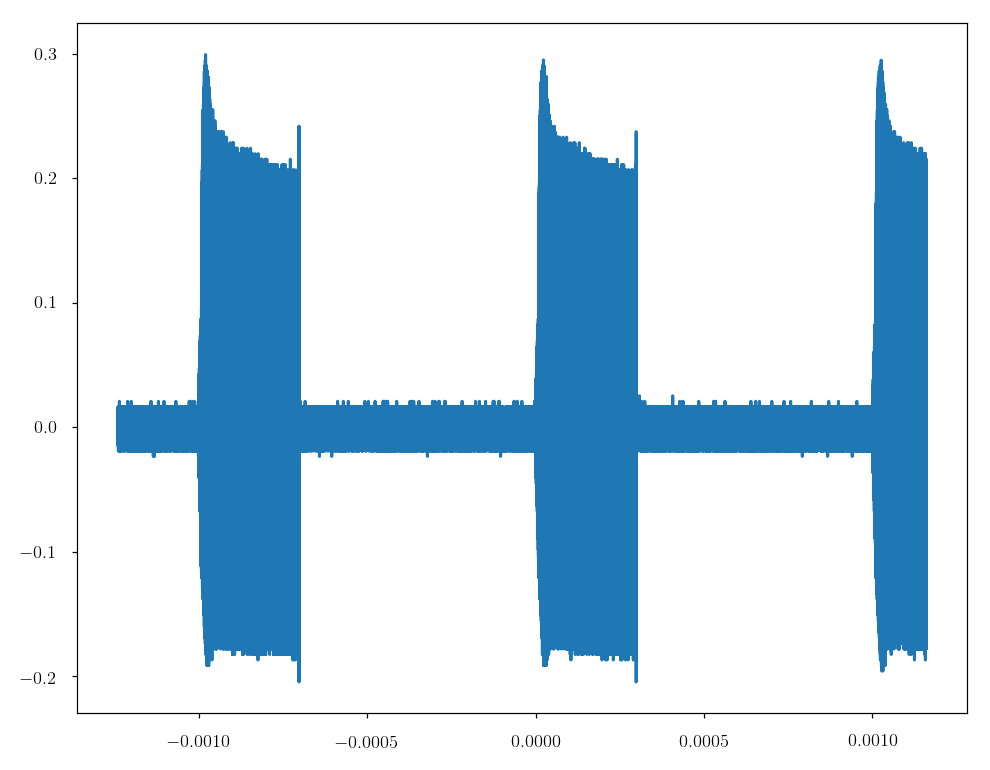

In [6]:
#Nejprve zkusím vykreslit data jen tak
plt.figure("Zkouška dat")   #Vytvořím graf s názvem "Zkouška dat"
plt.plot(t,U)               #Vykreslím závislost napětí na čase
plt.show("Zkouška dat")     #Ukážu graf s názvem "Zkouška dat"
#Název grafu ve figure a show je povinný pro používání "%matplotlib notebook", jinak
#se Vám vše bude vykreslovat do jednoho grafu

<IPython.core.display.Javascript object>


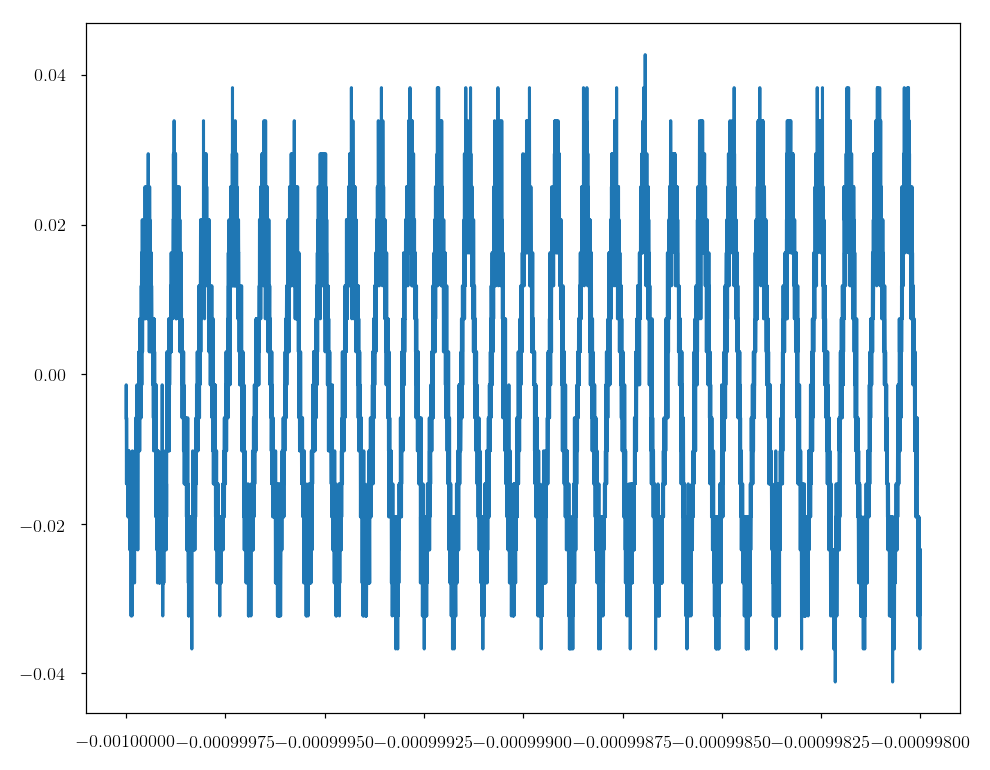

In [7]:
plt.figure("Oříznutí začátku pulzu")                   #Vytvořím graf
fr_start = 1200000    #Vytvořím proměnnou, která značí, odkud budu data vykreslovat
to_start = 1210000    #Vytvořím proměnnou, která značí, kam až budu data vykreslovat
plt.plot(t[fr_start:to_start],U[fr_start:to_start])    #Vykreslím závislost napětí na čase mezi fr_start a to_start
plt.show("Oříznutí začátku pulzu")                     #Ukážu graf
#Tuto buňku lze spustit několikrát a měnit proměnné, aby jste získali oblast, se kterou chcete pracovat.
#Dolní index "start" má značit, že ořezávám začátek pulzu

In [8]:
t_start = t[fr_start:to_start]    #Do proměnné "t_start" uložím výsek z "t", konkrétně mezi hodnotami fr_start a to_start
U_start = U[fr_start:to_start]    #Do proměnné "U_start" uložím výsek z "U" mezi hodnotami fr_start a to_start

<IPython.core.display.Javascript object>


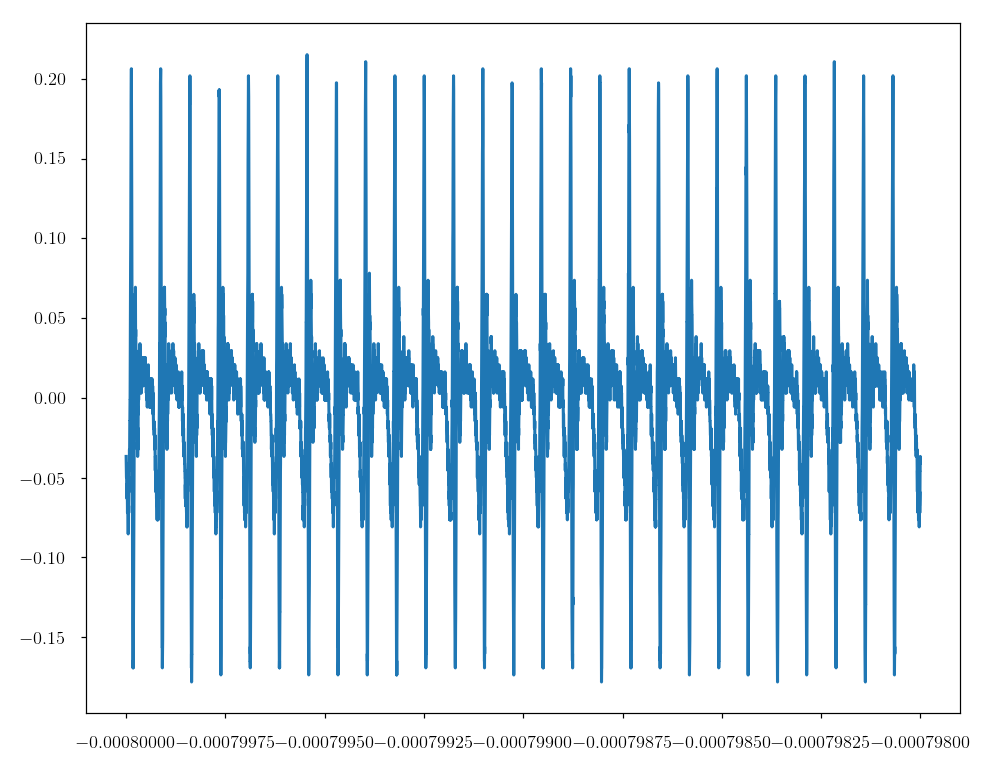

In [9]:
plt.figure("Oříznutí konce pulzu")
fr_end = 2200000
to_end = 2210000
plt.plot(t[fr_end:to_end],U[fr_end:to_end])
plt.show("Oříznutí konce pulzu")

In [10]:
U_end = U[fr_end:to_end]
t_end = U[fr_end:to_end]

# Zpracování

Abychom mohli provést Fourierovu analýzu, potřebujeme znát vzorkovací frekvenci osciloskopu. Je tedy třeba podívat se do informací o osciloskopu, které máme uložené v proměnné *info*.

In [11]:
info

{'ACQ_DURATION': 0.0,
 'ACQ_VERT_OFFSET': -0.0010000000474974513,
 'BANDWIDTH_LIMIT': 'off',
 'FIRST_POINT': 0,
 'FIRST_VALID_PNT': 0,
 'FIXED_VERT_GAIN': '100_uV/div',
 'HORIZ_INTERVAL': 2.000000026702864e-10,
 'HORIZ_OFFSET': -0.0012400001138300049,
 'HORIZ_UNCERTAINTY': 9.999999960041972e-13,
 'HORUNIT': 'S',
 'INSTRUMENT_NAME': 'LECROYWR6100A',
 'INSTRUMENT_NUMBER': 18520,
 'LAST_VALID_PNT': 12000010,
 'MAX_VALUE': 90.0,
 'MIN_VALUE': -91.0,
 'NOMINAL_BITS': 8,
 'NOM_SUBARRAY_COUNT': 1,
 'PAIR_OFFSET': 0,
 'PIXEL_OFFSET': -0.00124,
 'PNTS_PER_SCREEN': 12500000,
 'POINTS_PER_PAIR': 0,
 'PROBE_ATT': 1000.0,
 'PROCESSING_DONE': 'no_processing',
 'RECORD_TYPE': 'single_sweep',
 'RIS_SWEEPS': 1,
 'SEGMENT_INDEX': 0,
 'SPARSING_FACTOR': 1,
 'SUBARRAY_COUNT': 1,
 'SWEEPS_PER_ACQ': 1,
 'TIMEBASE': '500_us/div',
 'TRACE_LABEL': '',
 'TRIGGER_TIME': datetime.datetime(2017, 1, 18, 15, 5, 58, 405218),
 'USER_TEXT': '',
 'VERTICAL_GAIN': 0.004419455770403147,
 'VERTICAL_OFFSET': -0.003000000026

Hodnota 'HORIZ_INTERVAL' je hodnotou periody osciloskopu. Převrácená hodnota je vzorkovací frekvencí.

In [12]:
sampling_frequency = 1/2.000000026702864e-10

In [13]:
Uf_start = scipy.fftpack.fft(U_start)           #Provedu Fourierovu transformaci napětí
tf_start = scipy.fftpack.fftfreq(len(t_start))  #Provedu Fourierovu transformaci času, avšak abych dostal skutečné frekvence
tf_start = tf_start*sampling_frequency          #musím ještě násobit vzorkovací frekvencí

<IPython.core.display.Javascript object>


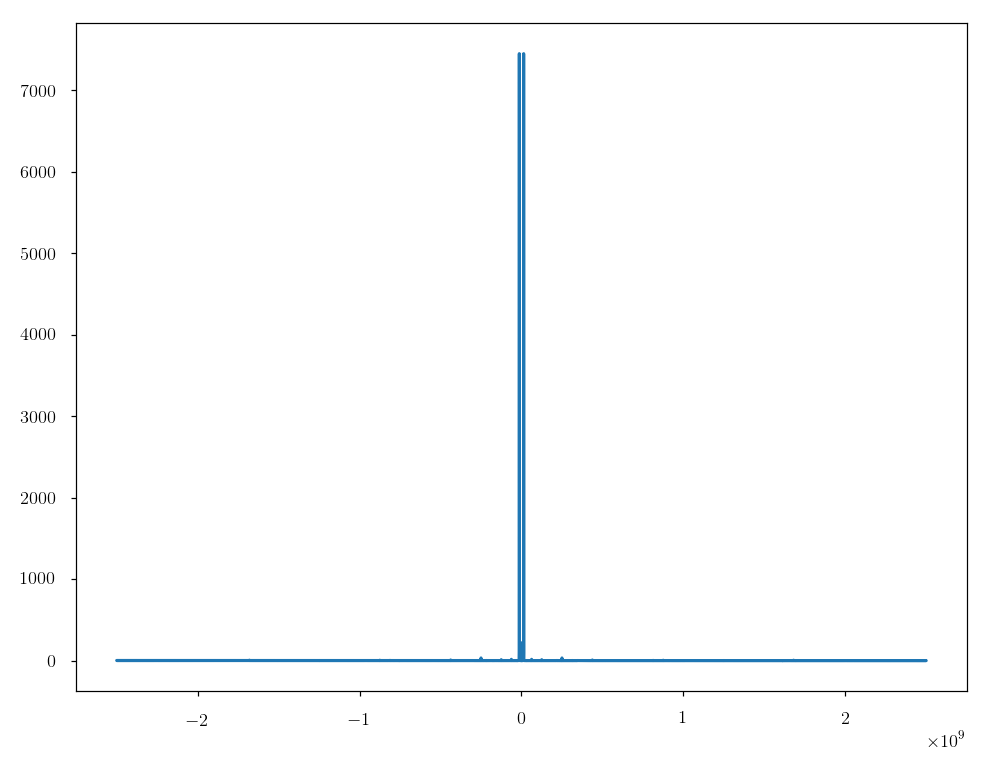

In [14]:
plt.figure("Fourierova analýza 1")
plt.plot(tf_start,np.real(Uf_start)**2)
plt.show("Fourierova analýza 1")

Není však nutné vytvářet takto Fourierovské spektrum "manuálně", jelikož v knihovně *scipy.signal* existuje funkce *periodogram*, která jej celé vytvoří za nás.

<IPython.core.display.Javascript object>


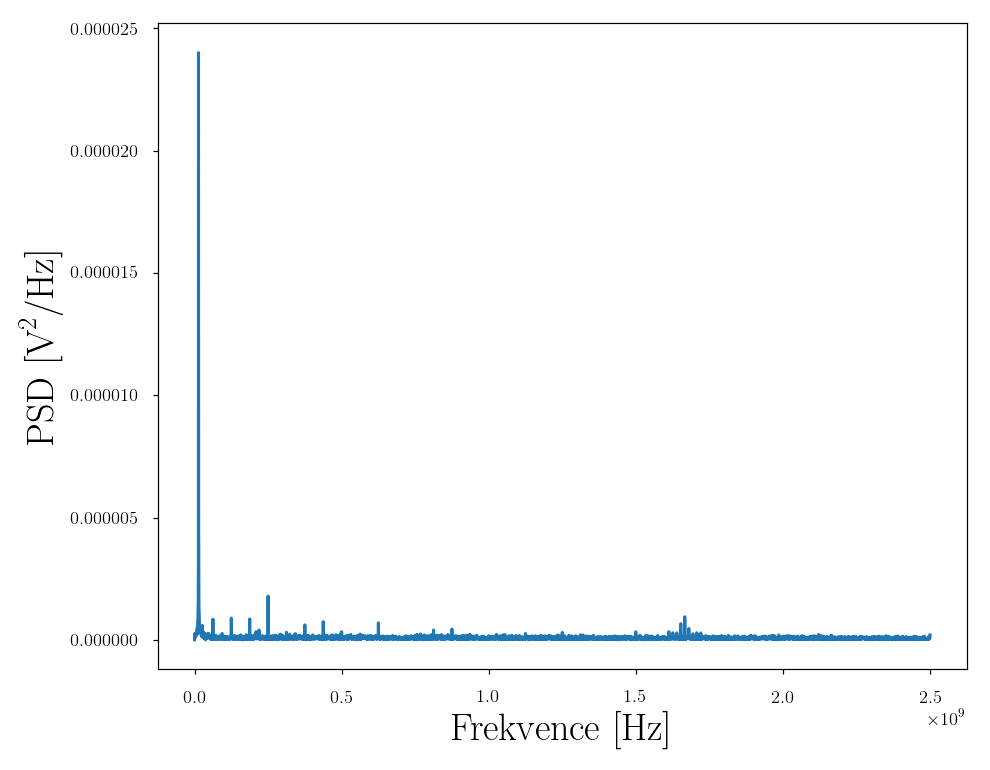

In [19]:
f_start, Pxx_den_start = scipy.signal.periodogram(U_start, sampling_frequency)
plt.figure("Periodogram začátku pulzu")
plt.plot(f_start, np.sqrt(Pxx_den_start))
plt.xlabel('Frekvence [Hz]')
plt.ylabel(r'PSD [V$^2$/Hz]')
plt.show("Periodogram začátku pulzu")

<IPython.core.display.Javascript object>


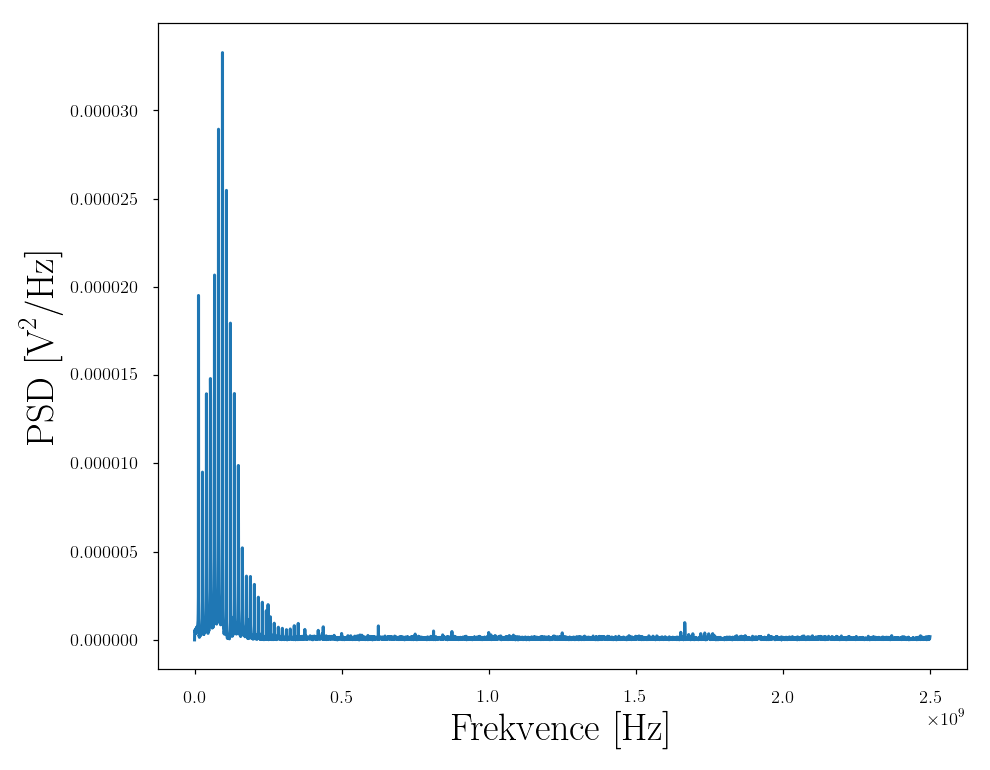

In [20]:
f_end, Pxx_den_end = scipy.signal.periodogram(U_end, sampling_frequency)
plt.figure("Periodogram konce pulzu")
plt.plot(f_end, np.sqrt(Pxx_den_end))
plt.xlabel('Frekvence [Hz]')
plt.ylabel(r'PSD [V$^2$/Hz]')
plt.show("Periodogram konce pulzu")

<IPython.core.display.Javascript object>


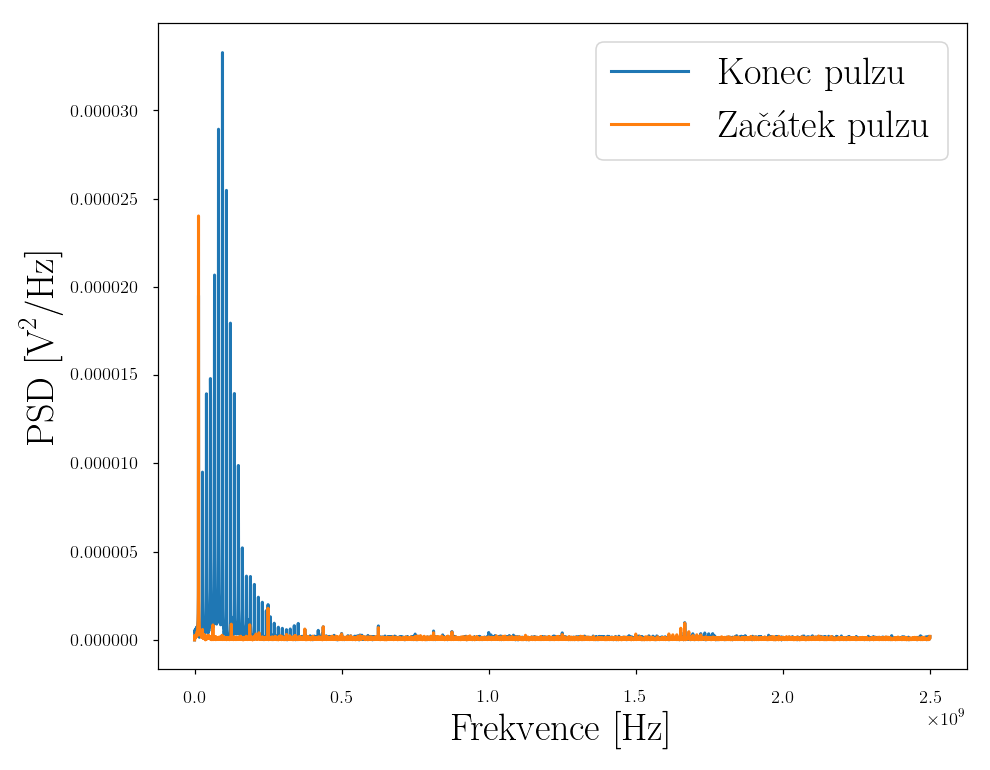

In [21]:
plt.figure("Periodogram")
plt.plot(f_end, np.sqrt(Pxx_den_end), label="Konec pulzu")
plt.plot(f_start, np.sqrt(Pxx_den_start), label="Začátek pulzu")
plt.xlabel('Frekvence [Hz]')
plt.ylabel(r'PSD [V$^2$/Hz]')
plt.legend()
plt.show("Periodogram")

# Shrnutí

Úspěšně jsme ověřili Dvořákovu hypotézu. Vidíme, že na začátku pulzu, obsahuje Fourierovské spektrum pouze jednu frekvenci, zatímco po delší době působení je vidět více frekvencí na násobcích budící frekvence.